# Imports

In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt

# Creating Environment

In [2]:
custom_map = [
    'SFFH',
    'FFFF',
    'HFFF',
    'HFFG'
]
 
env = gym.make('FrozenLake-v0', desc=custom_map, is_slippery=False)

In [3]:
env.action_space.n

4

In [4]:
env.observation_space.n

16

# Environment Example  

### Initial State

In [5]:
env.reset()
env.render()


SFFH
FFFF
HFFF
HFFG


### Stepping right twice

In [6]:
env.step(2)
env.step(2)
env.render()

  (Right)
SFFH
FFFF
HFFF
HFFG


### Stepping downwards thrice 

In [7]:
env.step(1)
env.step(1)
env.step(1)
env.render()

  (Down)
SFFH
FFFF
HFFF
HFFG


### Stepping right once for Goal state

In [8]:
env.step(2)
env.render()

  (Right)
SFFH
FFFF
HFFF
HFFG


# Dynamic Q-Learning

In [9]:
class TabularDynaQ:
    def __init__(self, num_states, num_actions, alpha, gamma, epsilon, n):
        self.Q = np.zeros((num_states, num_actions))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n = n
        self.model = {}
        
    def update_Q(self, s, a, r, s_prime):
        max_Q = np.max(self.Q[s_prime, :])
        td_error = r + self.gamma * max_Q - self.Q[s, a]
        self.Q[s, a] += self.alpha * td_error
        
    def update_model(self, s, a, r, s_prime):
        if s not in self.model:
            self.model[s] = {}
        self.model[s][a] = (r, s_prime)
        
    def sample_model(self):
        s = np.random.choice(list(self.model.keys()))
        a = np.random.choice(list(self.model[s].keys()))
        r, s_prime = self.model[s][a]
        return s, a, r, s_prime
        
    def plan(self):
        for i in range(self.n):
            s, a, r, s_prime = self.sample_model()
            max_Q = np.max(self.Q[s_prime, :])
            td_error = r + self.gamma * max_Q - self.Q[s, a]
            self.Q[s, a] += self.alpha * td_error
        
    def get_action(self, s):
        if np.random.rand() < self.epsilon:
            a = np.random.randint(self.Q.shape[1])
        else:
            a = np.argmax(self.Q[s, :])
        return a

# Defining Agent

In [10]:
agent = TabularDynaQ(num_states=env.observation_space.n, 
                      num_actions=env.action_space.n, 
                      alpha=0.1, gamma=0.9, epsilon=0.5, n=5)

# Training & Testing

In [11]:
num_episodes = 1000
for i in range(num_episodes):
    s = env.reset()
    done = False
    while not done:
        a = agent.get_action(s)
        s_prime, r, done, info, = env.step(a)
        agent.update_Q(s, a, r, s_prime)
        agent.update_model(s, a, r, s_prime)
        agent.plan()
        s = s_prime

num_episodes = 10
total_reward = 0
for i in range(num_episodes):
    s = env.reset()
    done = False
    while not done:
        a = np.argmax(agent.Q[s, :])
        s_prime, r, done, info = env.step(a)
        s = s_prime
        total_reward += r
print("Average testing reward:", total_reward / num_episodes)

Average testing reward: 1.0


# Q Table Plot
### Blue -> Start State | Red -> End State | Green -> Goal State

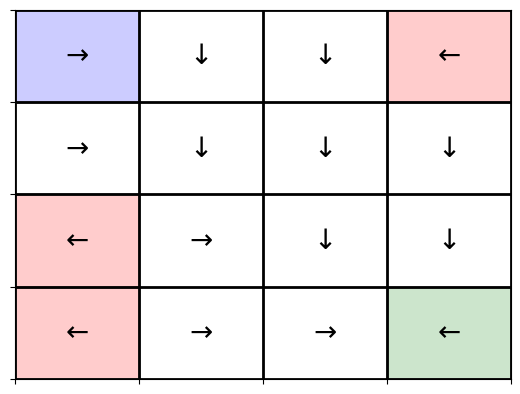

In [12]:
prob_grid = np.reshape(agent.Q, (4, 4, 4))

arrows = ['←', '↓', '→', '↑']

fig, ax = plt.subplots()
ax.set_xticks(np.arange(-0.5, 4.5, 1))
ax.set_yticks(np.arange(-0.5, 4.5, 1))
ax.grid(which='both', color='black', linestyle='-', linewidth=2)
ax.set_xticklabels([])
ax.set_yticklabels([])
for i in range(4):
    for j in range(4):
        optimal_action = np.argmax(prob_grid[i, j])
        ax.text(j, 3 - i, arrows[optimal_action], ha='center', va='center', fontsize=20)

rects = [plt.Rectangle((-0.5, 2.5), 1, 1, fc='blue', ec='black', lw=2, alpha=0.2),
         plt.Rectangle((-0.5, -0.5), 1, 1, fc='red', ec='black', lw=2, alpha=0.2), 
         plt.Rectangle((-0.5, 0.5), 1, 1, fc='red', ec='black', lw=2, alpha=0.2), 
         plt.Rectangle((2.5, 2.5), 1, 1, fc='red', ec='black', lw=2, alpha=0.2),
         plt.Rectangle((2.5, -0.5), 1, 1, fc='green', ec='black', lw=2, alpha=0.2)]

for rect in rects:
    ax.add_patch(rect)
    
plt.show()